<a href="https://colab.research.google.com/github/canhphu/ML/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2024-08-19 04:04:28--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2024-08-19 04:04:29 (4.59 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [ ]:
from tensorflow.keras.layers import StringLookup, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
CATE = ["sex", "smoker", "region"]
NUM = ["age", "bmi", "children"]
train_data = dataset.sample(frac=0.8, random_state=0)
test_data = dataset.drop(train_data.index)
train_labels = train_data.pop("expenses")
test_labels = test_data.pop("expenses")

In [ ]:
preprocessing_layers = {}
for feature_name in CATE:
    preprocessing_layers[feature_name] = StringLookup()
for feature_name in NUM:
    preprocessing_layers[feature_name] = Normalization()

In [ ]:
# Define input tensors
inputs = {
    feature_name: Input(shape=(1,), name=feature_name, dtype='string' if feature_name in CATE else 'float32')
    for feature_name in CATE + NUM
}

# Debugging: Print input shapes
print("Input shapes:")
for feature_name, tensor in inputs.items():
    print(f'{feature_name}: {tensor.shape}')

# Apply preprocessing layers
preprocessed_inputs = {}
for feature_name in CATE + NUM:
    layer = preprocessing_layers[feature_name]
    input_tensor = inputs[feature_name]
    preprocessed_inputs[feature_name] = layer(input_tensor)

# Debugging: Print preprocessed input shapes
print("\nPreprocessed input shapes:")
for feature_name, tensor in preprocessed_inputs.items():
    print(f'{feature_name}: {tensor.shape}')

# Convert data to tensors
train_data_tensors = {
    feature_name: tf.convert_to_tensor(train_data[feature_name].values.reshape(-1, 1), dtype=tf.float32)
    for feature_name in NUM
}
train_data_tensors.update({
    feature_name: tf.convert_to_tensor(train_data[feature_name].astype(str).values.reshape(-1, 1), dtype=tf.string)
    for feature_name in CATE
})

# Debugging: Print train data tensor shapes
print("\nTrain data tensor shapes:")
for feature_name, tensor in train_data_tensors.items():
    print(f'{feature_name}: {tensor.shape}')

# Adapt preprocessing layers
for feature_name in CATE:
    layer = preprocessing_layers[feature_name]
    layer.adapt(train_data_tensors[feature_name])

for feature_name in NUM:
    layer = preprocessing_layers[feature_name]
    layer.adapt(train_data_tensors[feature_name])

# Combine preprocessed inputs
concatenated_inputs = concatenate(list(preprocessed_inputs.values()))
preprocessing_model = Model(inputs=inputs, outputs=concatenated_inputs)

Input shapes:
sex: (None, 1)
smoker: (None, 1)
region: (None, 1)
age: (None, 1)
bmi: (None, 1)
children: (None, 1)

Preprocessed input shapes:
sex: (None, 1)
smoker: (None, 1)
region: (None, 1)
age: (None, 1)
bmi: (None, 1)
children: (None, 1)

Train data tensor shapes:
age: (1070, 1)
bmi: (1070, 1)
children: (1070, 1)
sex: (1070, 1)
smoker: (1070, 1)
region: (1070, 1)


In [ ]:
print(preprocessing_layers)
print("Shape of concatenated inputs:", concatenated_inputs.shape)
print("Shape of preprocessed features:", preprocessing_model.output_shape)  # Should match expected output

{'sex': <StringLookup name=string_lookup, built=True>, 'smoker': <StringLookup name=string_lookup_1, built=True>, 'region': <StringLookup name=string_lookup_2, built=True>, 'age': <Normalization name=normalization, built=True>, 'bmi': <Normalization name=normalization_1, built=True>, 'children': <Normalization name=normalization_2, built=True>}
Shape of concatenated inputs: (None, 6)
Shape of preprocessed features: (None, 6)


In [ ]:
def df_to_dataset(dataframe, labels, num_epochs=1, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds

def preprocess(features, labels):
    preprocessed_features = preprocessing_model(features)
    return preprocessed_features, labels
batch_size = 32
train_ds = df_to_dataset(train_data, train_labels, batch_size=batch_size)
test_ds = df_to_dataset(test_data,test_labels, shuffle=False, batch_size=batch_size)

train_dataset = train_ds.map(preprocess)
test_dataset = test_ds.map(preprocess)

In [ ]:
# Define and compile the model
model = Sequential()
model.add(Input(shape=(concatenated_inputs.shape[1],)))  # Kích thước đầu vào nên khớp với đầu ra kết hợp
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1, activation='linear'))
optimizer = Adam(learning_rate=0.01)  # You can adjust the learning rate
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])  # Mean squared error for regression# Preprocess the DataFrame features
model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 312939200.0000 - mae: 12917.8008 - val_loss: 223396208.0000 - val_mae: 9541.7607
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 157322080.0000 - mae: 8740.0566 - val_loss: 121485568.0000 - val_mae: 8281.5303
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 105876856.0000 - mae: 8000.5708 - val_loss: 105235760.0000 - val_mae: 7597.7725
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 85861888.0000 - mae: 7489.3467 - val_loss: 83977688.0000 - val_mae: 6877.2632
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 80784072.0000 - mae: 6856.1401 - val_loss: 64235076.0000 - val_mae: 6012.5366
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 55003064.0000 - mae: 5931.9419 - val_loss: 54188656.0000 - val_mae: 4864.9170
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 43041968.0000 - mae: 4626.6128 - val_loss: 47580796.0000 - val_mae: 4716.4116
Epoch 8/100
34/34 ━━━━━━━━━━━

9/9 - 0s - 5ms/step - loss: 34793668.0000 - mae: 3108.2102
Testing set Mean Abs Error: 3108.21 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


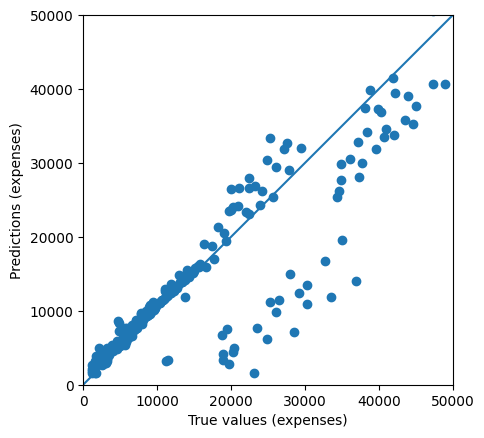

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae = model.evaluate(test_dataset, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
